In [3]:
import torch
import numpy as np
import os


In [4]:
def printScore(file):
    directory = '/home/thire399/Documents/School/DC-MasterThesis-2023/Data/Loss_chest_xray/'
    os.chdir(directory)
    train = torch.load('train_loss' + file + '.pt').tolist()
    val = torch.load('val_loss' + file + '.pt').tolist()
    print('min train accuracy {0}\nmin val accuracy   {1}\nAfter {2} epochs'.format(
                    np.round(1-min(train),3 ),
                    np.round(1-min(val), 3),
                    val.index(min(val))))
    return None

device: cuda:0
tensor(1)
torch.Size([1, 3, 64, 64])


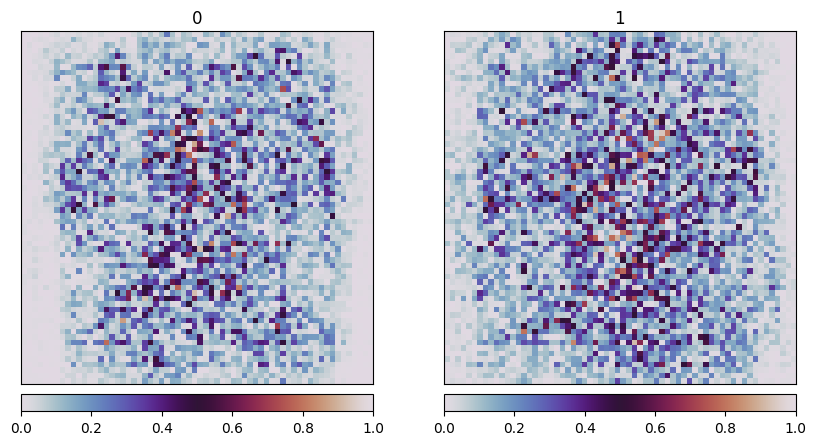

In [18]:
import captum.attr
import os
import torch
from captum.attr import visualization as viz
import matplotlib.pyplot as plt
from torchvision import models
import Models as M
import gc
import torch.nn as nn
os.chdir('/home/thire399/Documents/School/DC-MasterThesis-2023')
#del model 
gc.collect()
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)
dataSet = 'chest_xray'

model = models.alexnet(pretrained = False)
model.classifier[6] = nn.Linear(in_features=4096, out_features = 2, bias=True)
#os.chdir('/home/thire399/Documents/School/DC-MasterThesis-2023/Data/Loss_chest_xray/model128x128FullAlexNet20230411-213110.pt')
model.load_state_dict(torch.load(f'Data/Loss_chest_xray/model128x128FullAlexNet20230411-213110'))
data = torch.load(f'Data/Proccesed/{dataSet}/trainX.pt')
y = torch.load(f'Data/Proccesed/{dataSet}/trainY.pt')
model.to(device)
print(str(y[1]))
model.eval()

IntegratedGradients = captum.attr.IntegratedGradients(model)
input1 = data[0].unsqueeze(0)
input2 = data[1].unsqueeze(0)
input1 = input1.repeat(1,3,1,1).float()
input2 = input2.repeat(1,3,1,1).float()
print(input1.shape)

attrDeepLift1 = IntegratedGradients.attribute(input1.to(device), target = 1)
attrDeepLift2 = IntegratedGradients.attribute(input2.to(device), target = 0)

vis_types = ["heat_map", "original_image"]
vis_signs = ["absolute_value", "absolute_value"]
#print(attrDeepLift1[0][1].squeeze().unsqueeze(2).cpu().detach().numpy().shape)
#print(input1[0][1].squeeze().unsqueeze(2).cpu().detach().numpy().shape)
#_ = viz.visualize_image_attr_multiple(attrDeepLift1[0][1].squeeze().unsqueeze(2).cpu().detach().numpy(),
#                                      input1[0][1].squeeze().unsqueeze(2).cpu().detach().numpy(),
#                                      vis_types,
#                                      vis_signs,
#                                      ["Integrated Gradients", "Image"],
#                                      show_colorbar = True,
#                                      cmap = 'twilight'
#                                     )

fig, ax = plt.subplots(1, 2, figsize = ( 10,10))
fig1, ax1 = viz.visualize_image_attr(attrDeepLift1[0][1].squeeze().unsqueeze(2).cpu().detach().numpy()+1e-10,
                                        plt_fig_axis = (fig, ax[0]),
                                        cmap = 'twilight',
                                        show_colorbar = True,
                                        title = str(y[0].item()),
                                        use_pyplot = False)
fig2, ax2 = viz.visualize_image_attr(attrDeepLift2[0][1].squeeze().unsqueeze(2).cpu().detach().numpy()+1e-10,
                                        plt_fig_axis = (fig, ax[1]),
                                        cmap = 'twilight',
                                        show_colorbar = True,
                                        title = str(y[1].item()),
                                        use_pyplot = False)
#plt.tight_layout()
#plt.show()

label 0
torch.Size([1, 64, 64])
torch.Size([960, 1, 64, 64])
Distribution torch.Size([960]) tensor(486)


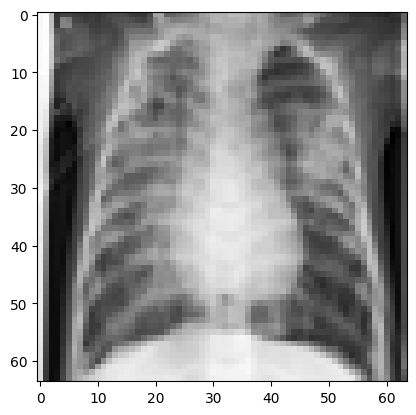

In [51]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
import os
index = 2
#dataset = 'Alzheimer_MRI'
dataset = 'chest_xray'
datasetType = 'Distribution'
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023/Data'
os.chdir(directory)
data = torch.load(f'Proccesed/{dataset}/'+ datasetType +'trainX.pt')
y = torch.load(f'Proccesed/{dataset}/'+ datasetType +'trainY.pt')
print(f'label {y[index]}')
print(data[index].shape)
print(data.shape)
#print(data[index])
plt.imshow(data[0][0], cmap = 'gray')
print('Distribution', y.shape, sum(y))
#print(torch.max(data[0]), torch.min(data[0]))
plt.show()


In [7]:
import Loop
import torch.nn as nn
from torchvision import models
import Models as M
import gc
os.chdir('/home/thire399/Documents/School/DC-MasterThesis-2023')
del model 
gc.collect()
#model = models.alexnet(pretrained = False)
#model.classifier[6] = nn.Linear(in_features=4096, out_features = 2, bias=True)
#model = models.resnet50(pretrained = False)
#model.fc = nn.Linear(in_features=2048, out_features = 2, bias=True)

model = M.UNet(enc_chs = (3, 64, 128, 256, 512, 1024)
               , dec_chs = (1024, 512, 256, 128, 64)
               , num_class = 1
               , df = 16384) # binary classification = 1.
batch_size   = 32
tempMOdel = "Data/Loss_chest_xray/model128x128FullUNet20230411-214841"
#Data parameters
dataSet      = 'chest_xray'
datatype     = ''
os.makedirs('Data/Loss_chest_xray/test', exist_ok = True)
costumLabel  = '64x64Full'

xVal = torch.load('Data/Proccesed/'+ dataSet + '/' + datatype +'tempValX.pt')
yVal = torch.load('Data/Proccesed/'+ dataSet + '/' + datatype +'tempValY.pt')

xVal = xVal.repeat(1, 3, 1, 1)     # only for pretrained model

tempval_Set = torch.utils.data.TensorDataset(xVal, yVal)
tempval_Loader = torch.utils.data.DataLoader(tempval_Set,
                                        batch_size = batch_size,
                                        shuffle = True,
                                        num_workers = 0)
p, t, fscore = Loop.eval_model(model = model
                , dataset = dataSet
                , dev = False
                , val_Loader = tempval_Loader
                , model_filePath = tempMOdel
                , size = costumLabel)

print('Accuracy on temp ValidationSet: {0}     --> (sum(Prediction = Target))/n_sampels'.format(np.sum([p == t])/t.shape[0]))


xVal = torch.load('Data/Proccesed/'+ dataSet + '/valX.pt')
yVal = torch.load('Data/Proccesed/'+ dataSet + '/valY.pt')

xVal = xVal.repeat(1, 3, 1, 1)     # only for pretrained model

val_Set = torch.utils.data.TensorDataset(xVal, yVal)
val_Loader = torch.utils.data.DataLoader(val_Set,
                                        batch_size = batch_size,
                                        shuffle = True,
                                        num_workers = 0)


p, t, fscore = Loop.eval_model(model = model
                , dataset = dataSet
                , dev = False
                , val_Loader = val_Loader
                , model_filePath = tempMOdel
                , size = costumLabel)



print('Accuracy on ValidationSet: {0}     --> (sum(Prediction = Target))/n_sampels'.format(np.sum([p == t])/t.shape[0]))
printScore('128x128FullUNet20230411-214841')


Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_chest_xray/model128x128FullUNet20230411-214841"
Data/Loss_chest_xray/model128x128FullUNet20230411-214841
     ===> F-Score: [64/1044 (6%)]	
     ===> F-Score: [128/1044 (12%)]	
     ===> F-Score: [192/1044 (18%)]	
     ===> F-Score: [256/1044 (24%)]	
     ===> F-Score: [320/1044 (30%)]	
     ===> F-Score: [384/1044 (36%)]	
     ===> F-Score: [448/1044 (42%)]	
     ===> F-Score: [512/1044 (48%)]	
     ===> F-Score: [576/1044 (55%)]	
     ===> F-Score: [640/1044 (61%)]	
     ===> F-Score: [704/1044 (67%)]	
     ===> F-Score: [768/1044 (73%)]	
     ===> F-Score: [832/1044 (79%)]	
     ===> F-Score: [896/1044 (85%)]	
     ===> F-Score: [960/1044 (91%)]	
     ===> F-Score: [1024/1044 (97%)]	
Best Threshold=1.000000, F-Score=0.965
Precision: 0.9712418300653595
Recall: 0.9587096774193549
Threshold: 1 (not used)
Accuracy on temp ValidationSet: 0.9482758620689655     --> (sum(Prediction = Target))/n_sampels
Using:  cuda:0
Model spe

In [ ]:
print("128x128 - alex all")
print("f1-score:")
print((0.983+0.981+0.985+0.980+0.981)/5)

print("epochs:")
print((43+39+45+42+36)/5)


print("128x128 - alex all")
print("f1-score:")
print((0.82)/5)

print("epochs:")
print((42)/5)

In [29]:
from carbontracker import parser
dataSet      = 'chest_xray'
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023'
os.chdir(directory)


parser.print_aggregate(log_dir= 'Data/Loss_' + dataSet + '/CarbonLogs')
logs = parser.parse_all_logs(log_dir = 'Data/Loss_' + dataSet + '/CarbonLogs')
first_log = logs[5]
print(f"Output file name: {first_log['output_filename']}")
print(f"Standard file name: {first_log['standard_filename']}")
print(f"Stopped early: {first_log['early_stop']}")
print(f"Measured consumption: {first_log['actual']}")
print(f"Predicted consumption: {first_log['pred']}")
print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")

The training of models in this work is estimated to use 0.054 kWh of electricity contributing to 0.004 kg of CO2eq. This is equivalent to 0.039 km travelled by car. Measured by carbontracker (https://github.com/lfwa/carbontracker).
Output file name: Data/Loss_chest_xray/CarbonLogs/64x64RandomUNet_17135_2023-04-03T191445Z_carbontracker_output.log
Standard file name: Data/Loss_chest_xray/CarbonLogs/64x64RandomUNet_17135_2023-04-03T191445Z_carbontracker.log
Stopped early: True
Measured consumption: {'epochs': 46, 'duration (s)': 149.0, 'energy (kWh)': 0.00382, 'co2eq (g)': 0.343831, 'equivalents': {'km travelled by car': 0.003198}}
Predicted consumption: {'epochs': 400, 'duration (s)': 1649.0, 'energy (kWh)': 0.038144, 'co2eq (g)': 4.144998, 'equivalents': {'km travelled by car': 0.038558}}
Measured GPU devices: ['NVIDIA GeForce RTX 3070 Laptop GPU']


Simple remake of the distribution coreset selection dataset into a temp validation set and train set.

In [ ]:
import os
import torch
from sklearn.model_selection import train_test_split

dataSet = 'chest_xray'
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023'
os.chdir(directory)
x = torch.load('Data/Proccesed/chest_xray/DistributiontrainXBeforeSplit.pt')
y = torch.load('Data/Proccesed/chest_xray/DistributiontrainYBeforeSplit.pt')
trainX, tempValX, trainY, tempValY = train_test_split(x, y, test_size = 0.2, random_state= 1)
torch.save(trainX, f = 'Data/Proccesed/chest_xray/DistributiontrainX.pt')
torch.save(trainY, f = 'Data/Proccesed/chest_xray/DistributiontrainY.pt')
torch.save(tempValX, f = 'Data/Proccesed/chest_xray/DistributiontempValX.pt')
torch.save(tempValY, f = 'Data/Proccesed/chest_xray/DistributiontempValY.pt')


In [20]:
''' Data processing file '''
import numpy as np
import matplotlib.pyplot as plt
import os 
import shutil
import torch
import CoreSet_Selection as CS
from PIL import Image
import gc
import re
from sklearn.model_selection import train_test_split
# Change for your own file path. Should only need to change this path. all other paths should be fine as is.!!

# TODO: update function description to standard.
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023/Data'
os.chdir(directory)
trainSize = 400
valSize = 100
imgSize = (64, 64)
vira = False


#Dataset to create
createANew = True
generateRandom = False
generateDistriution = False


#function to get all file names in the folder.
def GetFileNames(path = 'None', isVira = False):
    try:
        if isVira:
            return [os.path.join(path, file) for file in os.listdir(path) if re.search('_virus_', file)]
        else:
            return [os.path.join(path, file) for file in os.listdir(path)]
    except:
        print('Path "{0}" Not found'.format(path))

def MoveFiles(fileNames, source, destination):
    # Note copy has odd behaviour. - Depricated -> Now using "SaveToTensor"
    #Removes all content in folder first
    for f in os.listdir(destination):
        os.remove(os.path.join(destination, f))
    # copys the files in the original folder to the new folder
    for f in fileNames:
        src_path = os.path.join(source, f)
        dst_path = os.path.join(destination, f)
        shutil.copy(src_path, dst_path)
    print('moved all files to "{0}"'.format(destination))
    return None

def SaveToTensor(images, h = 32, w = 32):
    ''' should take in a image and resize it tot h x w (keep layers?). TODO: update description'''
    imgList = []
    k = 0
    for i in images:
        if k % 50 == 20:
            print(f'iteration {k}/{len(images)}')
            break
        img = Image.open(i)
        newImg = np.array(img.resize((h, w)).convert('L')).astype(np.float32)/255#resizes and converts to grayscale
        #, Image.ANTIALIAS) #'Provides smothing' should not perform this probably.
        imgList.append(torch.unsqueeze(torch.from_numpy(newImg), 0)) # ndarray -> tensor and adding 1 dimension (C x H x W)
        k += 1
    return torch.stack(imgList)
print('preparing training data...')
#Train data
normal = GetFileNames('UnProccesed/chest_xray/train/NORMAL')
normalTensor = SaveToTensor(normal, imgSize[0], imgSize[1])
for i in range(normalTensor.shape[0]):
    print(normalTensor[i].max(),normalTensor[0].min())

preparing training data...
iteration 20/1341
tensor(0.9137) tensor(0.)
tensor(0.9176) tensor(0.)
tensor(0.8667) tensor(0.)
tensor(0.9294) tensor(0.)
tensor(0.9176) tensor(0.)
tensor(0.9608) tensor(0.)
tensor(0.9451) tensor(0.)
tensor(0.9804) tensor(0.)
tensor(0.8588) tensor(0.)
tensor(0.8980) tensor(0.)
tensor(0.8039) tensor(0.)
tensor(0.9843) tensor(0.)
tensor(0.9686) tensor(0.)
tensor(0.9451) tensor(0.)
tensor(0.9373) tensor(0.)
tensor(0.9059) tensor(0.)
tensor(0.8314) tensor(0.)
tensor(0.9216) tensor(0.)
tensor(0.8980) tensor(0.)
tensor(0.8941) tensor(0.)
